# RBF-AR methods comparison

This notebook generates a synthetic time series, constructs a design matrix using one of the two approaches, runs either the OLS or SVD-based optimizer, and visualizes the reconstruction performance.


In [34]:
# Imports and configuration
from dataclasses import dataclass
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from design_matrix_constructor import (
    RadialBasisFunction,
    estimate_sigma_median,
    construct_design_matrix_with_local_pretraining,
    construct_design_matrix_with_no_pretraining,
)
from ols_optimizer import OlsOptimizer
from svd_based_optimizer import SvdOptimizer
from optimizer import Optimizer


@dataclass
class Config:
    approach: str = "no_pretraining"  # "no_pretraining" | "local_pretraining"
    optimizer: Optimizer = SvdOptimizer()  # instance implementing optimize(P, d)
    l: int = 1000  # samples
    n: int | None = None  # AR order (features per row)
    m: int = 100     # number of candidate centres
    noise: float = 0.05
    sigma: float | None = None  # None -> heuristic
    rbf: RadialBasisFunction = RadialBasisFunction.GAUSSIAN  # enum value, not tuple
    ridge: float = 1e-4  # only for local_pretraining
    rho: float = 0.2  # only for local_pretraining
    t_max: float = 40.0
    max_embedding_dim: int = 20  # for Cao's method
    post_tune: bool = True  # whether to do post-tuning of weights

cfg = Config(
    # approach="no_pretraining",
    approach="local_pretraining",
    # optimizer=OlsOptimizer(rho=0.6),
    optimizer=SvdOptimizer(epsilon=0.05, alpha=1),
    t_max=750.0,
    post_tune=True,
    noise=0.4,
    m=1600,
    l=2000,
)

In [15]:
def make_time_series(l=cfg.l, noise=cfg.noise, seed=0, t_max=cfg.t_max):
    rng = np.random.default_rng(seed)
    t = np.linspace(0, t_max*np.pi, l)
    y = (
        0.6*np.sin(0.6*t)
        + 0.3*np.sin(1.3*t + 0.5)
        + 0.1*np.sin(2.1*t + 1.2)
        + np.exp(-0.1*t)*np.sin(3.7*t + 0.7)
        + 0.6*np.exp(-np.abs(t_max / 2 -0.01*t))*np.sin(0.4*t + 2.1)*np.cos(1.8*t + 0.3)
    )
    return y.astype(np.float32) + noise * rng.standard_normal(l), y.astype(np.float32)


In [16]:
from scipy import signal
from scipy.spatial import KDTree

# Generate synthetic time series and construct lagged features (X, d)


def make_lagged_matrix(y, n, tau):
    # X in R^{(l - n*tau) x n}, d in R^{(l - n*tau)}
    l = len(y)
    X = np.stack([y[i: l - n*tau + i] for i in range(0, n*tau, tau)], axis=1)
    d = y[n*tau:]
    return X, d

# Generate the time series first to estimate tau
series, pure_series = make_time_series()

# Compute autocorrelation
autocorr_full = signal.correlate(series, series, mode='full')
lags_full = signal.correlation_lags(len(series), len(series), mode='full')

# Focus on positive lags
autocorr = autocorr_full[len(series)-1:] / autocorr_full[len(series)-1]
lags = lags_full[len(series)-1:]
# Set tau to the lag of the maximum autocorrelation (excluding lag 0)
tau = lags[np.argmax(autocorr[1:]) + 1] if len(autocorr) > 1 else 100

print(f"Tau: {tau}")

def estimate_embedding_dimension_cao(y, max_m=cfg.max_embedding_dim):
    y = np.asarray(y, dtype=np.float64)  # Ensure NumPy array
    l = len(y)
    e1_values = []
    
    for m in range(1, max_m + 1):
        if l - m < 2:
            break
        # Create embedded vectors
        X = np.array([y[i:i + m] for i in range(l - m)])
        
        # Build KDTree for efficient NN search
        tree = KDTree(X)
        
        # Find nearest neighbors (excluding self)
        distances, indices = tree.query(X, k=2)  # k=2 to get the closest (second is NN)
        nn_indices = indices[:, 1]  # Nearest neighbor index
        
        # Compute differences
        diffs = np.abs(y[m:l] - y[nn_indices + m])
        e1_m = np.mean(diffs)
        e1_values.append(e1_m)
    
    if len(e1_values) < 3:
        return 2  # default minimum
    
    # Compute E2 values
    e2_list = []
    for idx in range(1, len(e1_values) - 1):
        e2 = e1_values[idx + 1] / e1_values[idx]
        e2_list.append(e2)
    
    # Find first local minimum in E2
    for i in range(1, len(e2_list) - 1):
        if e2_list[i] < e2_list[i - 1] and e2_list[i] < e2_list[i + 1]:
            return i + 2  # m = i + 2 since e2_list[0] is for m=2
    
    return max_m

estimated_n = estimate_embedding_dimension_cao(series)
cfg.n = estimated_n
print(f"Estimated embedding dimension n: {estimated_n}")

# Now create the lagged matrix with estimated tau
X_np, d_np = make_lagged_matrix(series, cfg.n, tau)

X = torch.from_numpy(X_np)
d = torch.from_numpy(d_np)

l_eff = X.shape[0]
# candidate centres: pick first m or all rows if m > l
m = min(cfg.m, l_eff)
candidate_indices = torch.arange(m, dtype=torch.long)

print(f"X: {tuple(X.shape)}, d: {tuple(d.shape)}, candidates: {m}")


Tau: 53
Estimated embedding dimension n: 4
X: (1788, 4), d: (1788,), candidates: 1600


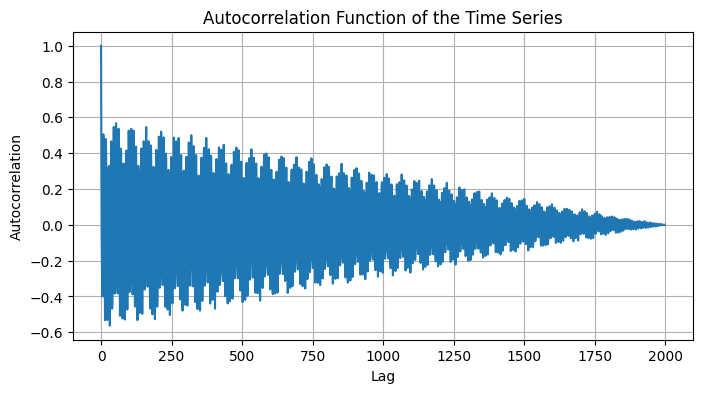

In [17]:
# Plot the autocorrelation function
plt.figure(figsize=(8, 4))
plt.plot(lags, autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function of the Time Series')
plt.grid(True)
plt.show()

In [18]:
# Split into train/test and precompute sigma


split = int(0.8 * l_eff)
X_train, X_test = X[:split], X[split:]
d_train, d_test = d[:split], d[split:]
d_train_pure, d_test_pure = pure_series[-len(X):][:split], pure_series[-len(X):][split:]

# Candidate centres remain the same indices for the full dataset; for fair use,
# we can restrict centres to train rows if desired. Here we use train indices.
train_candidates = torch.randperm(X_train.shape[0], dtype=torch.long)[:min(cfg.m, X_train.shape[0])]

# Compute sigma once (heuristic) on the training set for reproducibility
sigma_val = (
    estimate_sigma_median(X_train, train_candidates).item()
    if cfg.sigma is None
    else cfg.sigma
)
print(f"sigma used: {sigma_val:.6f}" if isinstance(sigma_val, float) else f"sigma used: {sigma_val}")


sigma used: 1.535994


In [35]:

# Build train P
if cfg.approach == "no_pretraining":
    P_train = construct_design_matrix_with_no_pretraining(
        X_train, d_train, candidate_indices=train_candidates, radial_basis_function=cfg.rbf, sigma=sigma_val
    )
elif cfg.approach == "local_pretraining":
    P_train, nu_hat_train = construct_design_matrix_with_local_pretraining(
        X_train, d_train, candidate_indices=train_candidates, radial_basis_function=cfg.rbf, sigma=sigma_val, ridge=cfg.ridge, rho=cfg.rho, return_weights=True
    )
else:
    raise ValueError("Unknown approach")

# Choose optimizer (fit on train)

sel_idx, weights = cfg.optimizer.optimize(P_train, d_train)

print(f"Selected {sel_idx.numel()} atoms")

# Build test P so that its columns correspond to TRAIN centres
if cfg.approach == "no_pretraining":
    lt = X_test.shape[0]
    X_stack = torch.cat([X_test, X_train], dim=0)
    # d is unused for this approach, but must have correct length
    d_stack = torch.zeros(X_stack.shape[0], dtype=X_stack.dtype)
    cand_stack = train_candidates + lt  # offset into the training part
    P_stack = construct_design_matrix_with_no_pretraining(
        X_stack, d_stack, candidate_indices=cand_stack, radial_basis_function=cfg.rbf, sigma=sigma_val
    )
    P_test = P_stack[:lt]
else:
    centres =  X_train[train_candidates]
    x_sq = (X_test * X_test).sum(dim=1, keepdim=True)
    centres_sq = (centres * centres).sum(dim=1)
    dist_sq = (x_sq + centres_sq.unsqueeze(0)) - 2.0 * (X_test @ centres.transpose(0, 1))
    dist_sq = torch.clamp(dist_sq, min=0.0)
    
    match cfg.rbf:
        case RadialBasisFunction.GAUSSIAN:
            denom = 2 * (sigma_val ** 2)
            phi = torch.exp(-dist_sq / denom)
        case RadialBasisFunction.LAPLACIAN:
            denom = sigma_val + 1e-12
            phi = torch.exp(-torch.sqrt(dist_sq + 1e-12) / denom)
    
    P_test = phi * (X_test @ nu_hat_train.T)

# Stash for analysis
P_train, P_test, sel_idx, weights = P_train, P_test, sel_idx, weights

Selected 1430 atoms


In [37]:
tuning_num_epochs = 1000
tuning_lr = 1e-3

In [38]:
if cfg.post_tune:
    
    model_weights_before_tuning = weights.clone().detach()
    
    # Post-tune the selected weights using Adam with early stopping
    weights = torch.nn.Parameter(weights.clone().detach())
    
    # Split training data into train and validation (10% for validation)
    val_size_pt = int(0.1 * X_train.shape[0])
    train_size_pt = X_train.shape[0] - val_size_pt
    X_train_split = X_train[:train_size_pt]
    d_train_split = d_train[:train_size_pt]
    X_val_split = X_train[train_size_pt:]
    d_val_split = d_train[train_size_pt:]
    
    optim = torch.optim.Adam([weights], lr=tuning_lr)
    # optim = torch.optim.RMSprop([weights], lr=tuning_lr)
    # optim = torch.optim.SGD([weights], lr=tuning_lr)
    
    # Early stopping parameters
    patience = 10  # number of epochs to wait for improvement
    best_val_loss = float('inf')
    best_epoch = 0
    best_weights = weights.clone()  # save initial as best
    
    progress_bar = tqdm(range(tuning_num_epochs), desc="Post-tuning")
    for epoch in progress_bar:
        # Training step
        optim.zero_grad()
        y_pred_tr = P_train[:train_size_pt, sel_idx] @ weights
        loss = torch.mean((y_pred_tr - d_train_split) ** 2)
        loss.backward()
        optim.step()
        
        # Validation step
        with torch.no_grad():
            y_pred_val = P_train[train_size_pt:, sel_idx] @ weights
            val_loss = torch.mean((y_pred_val - d_val_split) ** 2)
        
        progress_bar.set_postfix({"train_loss": loss.item(), "val_loss": val_loss.item()})
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss.item()
            best_epoch = epoch
            best_weights = weights.clone()  # save best weights
        elif epoch - best_epoch >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Restore best weights
    weights.data = best_weights.data
    weights = weights.detach()

Post-tuning:   2%|▏         | 22/1000 [00:00<00:39, 24.58it/s, train_loss=0.249, val_loss=0.233]

Early stopping at epoch 22


Relative error - train: 0.7798 | test: 0.8360


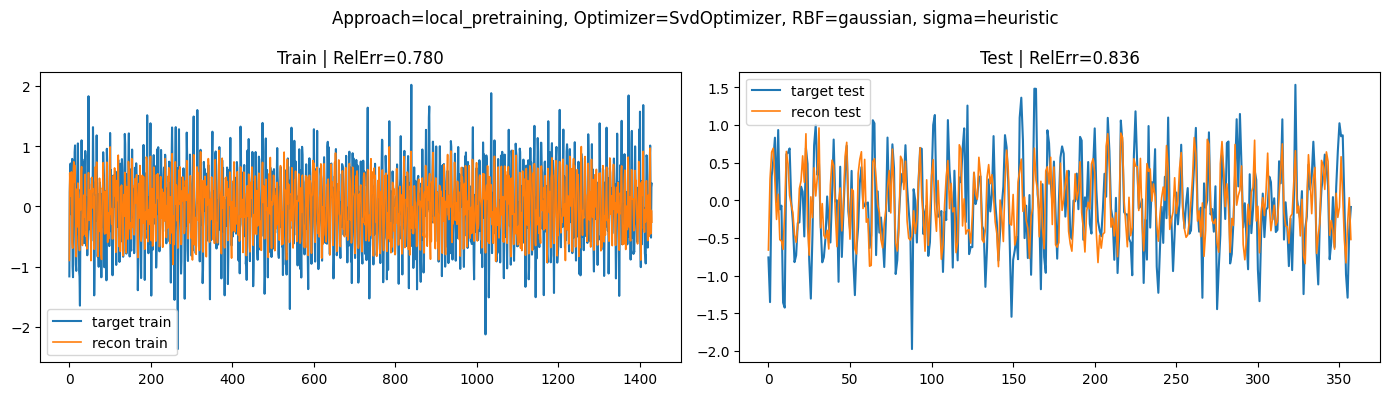

In [32]:
# Analyze reconstruction and visualize

def rel_err(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return torch.linalg.norm(a - b) / (torch.linalg.norm(b) + 1e-12)

with torch.no_grad():
    y_hat_train = torch.zeros_like(d_train)
    y_hat_test = torch.zeros_like(d_test)
    if sel_idx.numel() > 0:
        y_hat_train = P_train[:, sel_idx] @ weights
        y_hat_test = P_test[:, sel_idx] @ weights

rerr_train = float(rel_err(y_hat_train, d_train))
rerr_test = float(rel_err(y_hat_test, d_test))
print(f"Relative error - train: {rerr_train:.4f} | test: {rerr_test:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)
axes[0].plot(d_train.numpy(), label="target train", lw=1.5)
axes[0].plot(y_hat_train.numpy(), label="recon train", lw=1.2)
axes[0].set_title(f"Train | RelErr={rerr_train:.3f}")
axes[0].legend()

axes[1].plot(d_test.numpy(), label="target test", lw=1.5)
axes[1].plot(y_hat_test.numpy(), label="recon test", lw=1.2)
axes[1].set_title(f"Test | RelErr={rerr_test:.3f}")
axes[1].legend()

plt.suptitle(f"Approach={cfg.approach}, Optimizer={type(cfg.optimizer).__name__}, RBF={str(cfg.rbf)}, sigma={'heuristic' if cfg.sigma is None else cfg.sigma}")
plt.tight_layout()
plt.show()


In [51]:
# Control model: Adam-optimized centroids (and optional sigmas)

# Hyperparameters for the control model
ctrl_epochs = 1000
ctrl_lr = 5e-2
ctrl_weight_decay = 0
ctrl_train_sigma = True       # optimize sigma as well
ctrl_sigma_global = True      # if False, learn per-centre sigma
m_ctrl = 14

assert m_ctrl <= X_train.shape[0], "Control model m must be <= number of training samples"

In [52]:

# Split training data into train and validation (10% for validation)
val_size = int(0.1 * X_train.shape[0])
train_size = X_train.shape[0] - val_size
X_train_split = X_train[:train_size]
d_train_split = d_train[:train_size]
X_val_split = X_train[train_size:]
d_val_split = d_train[train_size:]

# Initialization
torch.manual_seed(0)
C_param = (
    X_train_split[torch.randperm(X_train_split.shape[0])[:m_ctrl]]
    .clone()
    .to(device=X_train_split.device, dtype=X_train_split.dtype)
    .detach()
    .requires_grad_(True)
)  # (m, n)
Theta_param = (
    (0.01 * torch.randn(m_ctrl, X_train_split.shape[1]))
    .to(device=X_train_split.device, dtype=X_train_split.dtype)
    .requires_grad_(True)
)  # (m, n)

if ctrl_sigma_global:
    # Use a single global sigma
    log_sigma_param = torch.tensor(
        np.log(float(sigma_val) + 1e-6),
        dtype=X_train_split.dtype,
        requires_grad=ctrl_train_sigma,
    )
else:
    # Per-centre sigma
    init_sigma = torch.full((m_ctrl,), float(sigma_val), dtype=X_train_split.dtype)
    log_sigma_param = torch.log(init_sigma + 1e-6)
    log_sigma_param.requires_grad_(ctrl_train_sigma)

params = [C_param, Theta_param]
if ctrl_train_sigma:
    params.append(log_sigma_param)

# optim = torch.optim.RMSprop(params, lr=ctrl_lr, weight_decay=ctrl_weight_decay)
optim = torch.optim.Adam(params, lr=ctrl_lr, weight_decay=ctrl_weight_decay)

def _phi_from_params(X_in, C, log_sigma):
    x_sq = (X_in * X_in).sum(dim=1, keepdim=True)  # (l, 1)
    c_sq = (C * C).sum(dim=1)  # (m,)
    dist_sq = x_sq + c_sq.unsqueeze(0) - 2.0 * (X_in @ C.T)  # (l, m)
    dist_sq = torch.clamp(dist_sq, min=0.0)

    if ctrl_sigma_global:
        sigma = torch.nn.functional.softplus(log_sigma) + 1e-6
    else:
        sigma = torch.nn.functional.softplus(log_sigma).unsqueeze(0) + 1e-6  # (1, m)

    match cfg.rbf:
        case RadialBasisFunction.GAUSSIAN:
            if ctrl_sigma_global:
                denom = 2.0 * (sigma * sigma)
            else:
                denom = 2.0 * (sigma * sigma)  # (1, m)
            phi = torch.exp(-dist_sq / denom)
        case RadialBasisFunction.LAPLACIAN:
            dist = torch.sqrt(dist_sq + 1e-12)
            phi = torch.exp(-dist / (sigma + 1e-12))
        case _:
            raise ValueError("Unknown RBF in config")
    return phi

# Early stopping parameters
patience = 10  # number of epochs to wait for improvement
best_val_loss = float('inf')
best_epoch = 0
best_params = [p.clone() for p in params]  # save initial as best

loss_hist = []

progress_bar = tqdm(range(1, ctrl_epochs + 1), desc="Control model training")
for epoch in progress_bar:
    # Training step
    phi_tr = _phi_from_params(X_train_split, C_param, log_sigma_param)  # (l_tr, m)
    proj_tr = X_train_split @ Theta_param.T  # (l_tr, m)
    y_hat_tr_ctrl = (phi_tr * proj_tr).sum(dim=1)  # (l_tr,)
    loss = torch.mean((y_hat_tr_ctrl - d_train_split) ** 2)

    optim.zero_grad()
    loss.backward()
    optim.step()

    # Validation step
    with torch.no_grad():
        phi_val = _phi_from_params(X_val_split, C_param, log_sigma_param)
        proj_val = X_val_split @ Theta_param.T
        y_hat_val_ctrl = (phi_val * proj_val).sum(dim=1)
        val_loss = torch.mean((y_hat_val_ctrl - d_val_split) ** 2)

    loss_hist.append(float(loss.detach()))
    progress_bar.set_postfix({"train_loss": loss.item(), "val_loss": val_loss.item()})

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss.item()
        best_epoch = epoch
        best_params = [p.clone() for p in params]  # save best params
    elif epoch - best_epoch >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Restore best parameters
for i, p in enumerate(params):
    p.data = best_params[i].data

# Evaluate on full train and test using best model
with torch.no_grad():
    phi_te = _phi_from_params(X_test, C_param, log_sigma_param)
    proj_te = X_test @ Theta_param.T
    y_hat_test_ctrl = (phi_te * proj_te).sum(dim=1)

# Also stash train preds for comparison
with torch.no_grad():
    phi_tr = _phi_from_params(X_train, C_param, log_sigma_param)
    proj_tr = X_train @ Theta_param.T
    y_hat_train_ctrl = (phi_tr * proj_tr).sum(dim=1)

print("Control model done.")

Control model training:   5%|▌         | 54/1000 [00:00<00:10, 89.73it/s, train_loss=0.241, val_loss=0.225]

Early stopping at epoch 55
Control model done.


Selected-atom RelErr train=0.7788, test=0.8359
Control-Adam   RelErr train=0.7722, test=0.8358


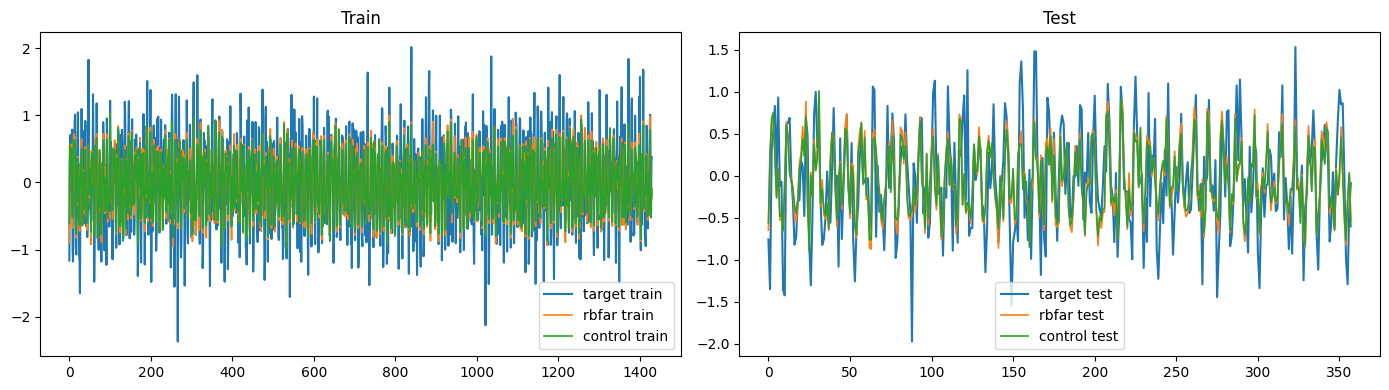

In [53]:
# Compare control model vs selected-atom reconstruction

def rel_err(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return torch.linalg.norm(a - b) / (torch.linalg.norm(b) + 1e-12)

rctrl_tr = float(rel_err(y_hat_train_ctrl, d_train))
rctrl_te = float(rel_err(y_hat_test_ctrl, d_test))

print(f"Selected-atom RelErr train={float(rel_err(P_train[:, sel_idx] @ weights, d_train)):.4f}, test={float(rel_err(P_test[:, sel_idx] @ weights, d_test)):.4f}")
print(f"Control-Adam   RelErr train={rctrl_tr:.4f}, test={rctrl_te:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)
axes[0].plot(d_train.numpy(), label="target train", lw=1.5)
axes[0].plot((P_train[:, sel_idx] @ weights).detach().numpy(), label="rbfar train", lw=1.2)
axes[0].plot(y_hat_train_ctrl.detach().numpy(), label="control train", lw=1.2)
axes[0].legend()
axes[0].set_title("Train")

axes[1].plot(d_test.numpy(), label="target test", lw=1.5)
axes[1].plot((P_test[:, sel_idx] @ weights).detach().numpy(), label="rbfar test", lw=1.2)
axes[1].plot(y_hat_test_ctrl.detach().numpy(), label="control test", lw=1.2)
axes[1].legend()
axes[1].set_title("Test")
plt.tight_layout()
plt.show()


## Comparing the results

Metrics (higher R/R2 is better; lower RMSE/MAAPE is better):
                                    R        R2      RMSE     MAAPE      MAPE
RBFAR before tuning - Train  0.792715  0.626459  0.293141  0.566998  1.699710
RBFAR - Train                0.792971  0.610985  0.299151  0.575788  1.857385
Control - Train              0.787567  0.616650  0.296965  0.570108  1.748435
RBFAR before tuning - Test   0.781428  0.602419  0.302414  0.588855  1.551256
RBFAR - Test                 0.781645  0.585452  0.308800  0.596714  1.688566
Control - Test               0.772148  0.584698  0.309080  0.588474  1.618157


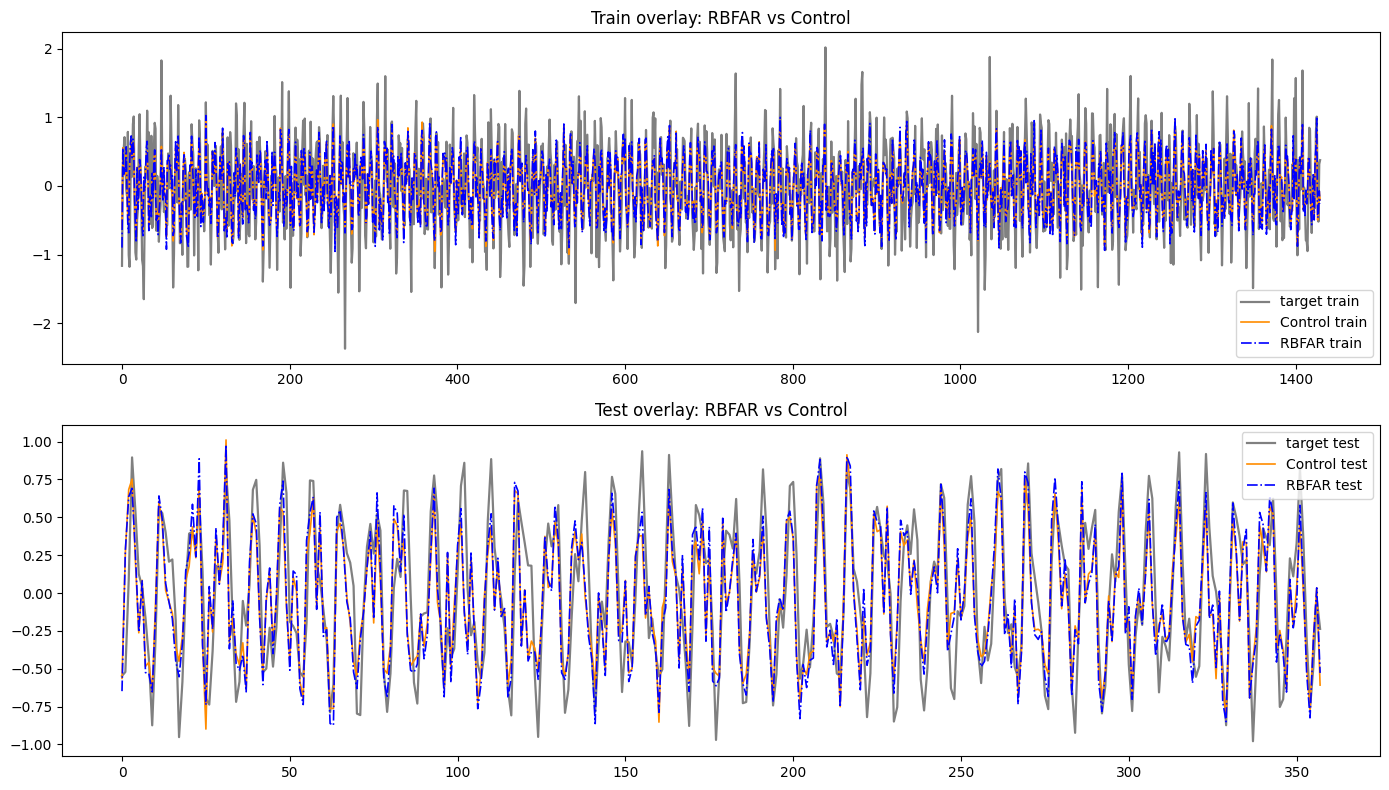

In [56]:
from permetrics import RegressionMetric
import pandas as pd

# Ensure predictions are available
rbfar_train = (P_train[:, sel_idx] @ weights).detach()
rbfar_test = (P_test[:, sel_idx] @ weights).detach()
ctrl_train = y_hat_train_ctrl.detach()
ctrl_test = y_hat_test_ctrl.detach()
if cfg.post_tune:
    rbfar_train_before = (P_train[:, sel_idx] @ model_weights_before_tuning).detach()
    rbfar_test_before = (P_test[:, sel_idx] @ model_weights_before_tuning).detach()

metric_list = ["R", "R2", "RMSE", "MAAPE", "MAPE"]

def compute_metrics(y_true: torch.Tensor, y_pred: torch.Tensor):
    rm = RegressionMetric(y_true.reshape(-1).cpu().numpy() if y_true is torch.Tensor else y_true, y_pred.reshape(-1).cpu().numpy())
    return {
        "R": rm.R(),
        "R2": rm.R2(),
        "RMSE": rm.RMSE(),
        "MAAPE": rm.MAAPE(),
        "MAPE": rm.MAPE(),
    }

rows = []
rows.append(("RBFAR before tuning - Train", compute_metrics(d_train_pure, rbfar_train_before)))
rows.append(("RBFAR - Train", compute_metrics(d_train_pure, rbfar_train)))
rows.append(("Control - Train", compute_metrics(d_train_pure, ctrl_train)))
rows.append(("RBFAR before tuning - Test", compute_metrics(d_test_pure, rbfar_test_before)))
rows.append(("RBFAR - Test", compute_metrics(d_test_pure, rbfar_test)))
rows.append(("Control - Test", compute_metrics(d_test_pure, ctrl_test)))

# Build DataFrame
records = []
index = []
for name, vals in rows:
    index.append(name)
    # vals is a dict like {metric_name: value}
    records.append([vals[m] for m in metric_list])

results_df = pd.DataFrame(records, index=index, columns=metric_list)
print("Metrics (higher R/R2 is better; lower RMSE/MAAPE is better):")
print(results_df.to_string())

# Overlay plots for Train and Test
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
axes[0].plot(d_train.cpu().numpy(), label="target train", lw=1.6, color="grey")
axes[0].plot(ctrl_train.cpu().numpy(), label="Control train", lw=1.2, color="darkorange", linestyle="-")
axes[0].plot(rbfar_train.cpu().numpy(), label="RBFAR train", lw=1.2, color="blue", linestyle="-.")
axes[0].set_title("Train overlay: RBFAR vs Control")
axes[0].legend()

axes[1].plot(d_test_pure, label="target test", lw=1.6, color="grey")
axes[1].plot(ctrl_test.cpu().numpy(), label="Control test", lw=1.2, color="darkorange", linestyle="-")
axes[1].plot(rbfar_test.cpu().numpy(), label="RBFAR test", lw=1.2, color="blue", linestyle="-.")
axes[1].set_title("Test overlay: RBFAR vs Control")
axes[1].legend()

plt.tight_layout()
plt.show()